# Ejercicio Antelacion de Compra

In [1]:
# leemos fichero de tickets
lts = sc.textFile("data/transm150720.csv")

In [2]:
lts.first()

u'79062005698500,TKTT,30,150719,FR,0.0,EUR,T,T,141025,PARA127A8,0.0,EUR,   ,EX,,150719,0.0'

In [3]:
# sacamos los datos que interesan: cols: 0 y 9
def getTCNFechaCompra(l):
    elems = l.split(",")
    tcn = elems[0]
    fechaCompra = elems[9]
    return(tcn, fechaCompra)

In [4]:
# Ojo que la fecha está en texto, luego lo debemos trabajar...
getTCNFechaCompra(lts.first())

(u'79062005698500', u'141025')

In [5]:
ts = lts.map(getTCNFechaCompra)

In [6]:
ts.take(3)
# numero de ticket y fecha. Siempre debemos mirar que las claves son únicas. Ej con un groupByKey

[(u'79062005698500', u'141025'),
 (u'79062005924069', u'150719'),
 (u'79065668570385', u'150626')]

In [7]:
lcs = sc.textFile("data/coupon150720.csv")

In [8]:
lcs.first()

u'79062005698500,1,MAA,AUH,9W,9W,56.79,USD,1,H,H,0526,150904,OK,IAF0'

In [9]:
# Aqui sabemos que las claves estan duplciadas.
def getTCNFechaSalida(l):
    elems = l.split(",")
    tcn = elems[0]
    fechaSalida = elems[12]
    return(tcn, fechaSalida)

In [10]:
cs = lcs.map(getTCNFechaSalida)

In [11]:
cs.take(3)
# se verá que hay claves repetidas.

[(u'79062005698500', u'150904'),
 (u'79062005698500', u'150905'),
 (u'79062005924069', u'150721')]

In [12]:
# coger la fecha más pequeña. Según esta año, mes, día se puede hacer por cadena de texto.
cgps = cs.groupByKey().mapValues(lambda vs: min(vs)).cache()

In [13]:
cgps.take(3)

[(u'79062005558463', u'150801'),
 (u'79065668432713', u'150823'),
 (u'79062005501193', u'150720')]

In [14]:
j = cgps.leftOuterJoin(ts).cache()

In [15]:
# tupla con clave y fecha salida y fecha de compra
j.take(3)

[(u'79062005994272', (u'150720', u'150719')),
 (u'79065668614400', (u'150724', u'150719')),
 (u'79062005501193', (u'150720', u'150719'))]

In [27]:
# calculamos la diferencia entre fechas en numero de dias.
from time import strptime
from time import mktime

In [47]:
def difFechas(f1, f2):
    of1 = strptime(f1,'%y%m%d')
    of2 = strptime(f2,'%y%m%d')
    segs1 = mktime(of1)
    segs2 = mktime(of2)
    dif = segs1 - segs2
    return (dif/(3600*24))

In [40]:
# Tenemos que quitar las cadenas vacías. Se debería haber hecho antes para evitar trabajar con ello.
fj = j.filter(lambda x: x[1][0] != '' and x[1][1] != '')

In [41]:
j.count()

631405

In [42]:
fj.count()

610328

In [50]:
# Nos va a devolver una tupla con el número de ticket con los días de antelación de compra.
d = fj.mapValues(lambda v: difFechas(v[0], v[1]))

In [51]:
d.take(3)

[(u'79062005994272', 1.0), (u'79065668614400', 5.0), (u'79062005501193', 1.0)]

In [52]:
d.map(lambda x: (x[1],1)).take(3)

[(1.0, 1), (5.0, 1), (1.0, 1)]

In [54]:
d.map(lambda x: (x[1],1)).reduceByKey(lambda e, accum: e + accum).take(3)

[(0.0, 28366), (750.0, 1), (198.04166666666666, 126)]

In [55]:
d.map(lambda x: (int(x[1]),1)).reduceByKey(lambda e, accum: e + accum).take(3)
# el de 515 días no estaría bien.

[(0, 28366), (515, 1), (5, 16793)]

In [56]:
r = d.map(lambda x: (int(x[1]),1)).reduceByKey(lambda e, accum: e + accum)

In [60]:
r.count()

452

In [58]:
# creamos la lista de tuplas para pintar.
res = r.collect()

In [61]:
# Ya es un objeto de python normal.
res[0:5]

[(0, 28366), (515, 1), (5, 16793), (10, 9906), (15, 7791)]

In [62]:
# Vamos a dibujarlo en un gráfico
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [64]:
# Separamos las tuplas en x e y
xs = [t[0] for t in res]

In [68]:
xs[0:5]

[0, 515, 5, 10, 15]

In [70]:
ys = [t[1] for t in res]

In [71]:
ys[0:5]

[28366, 1, 16793, 9906, 7791]

<Container object of 452 artists>

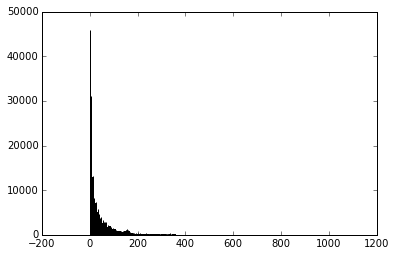

In [72]:
# Creamos el histograma.
plt.bar(xs, ys)

(0, 100)

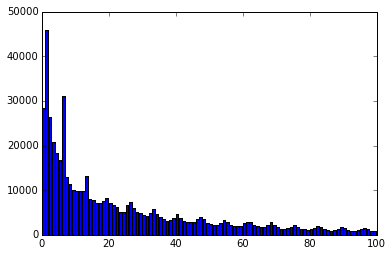

In [73]:
plt.bar(xs,ys)
plt.xlim(0,100)

# Ejercicio: Nube de puntos con días de antelación y valor medio del billete.

In [75]:
# Traerse arriba otro campo con el precio del billete y hacer cálculos....